
https://susanqq.github.io/UTKFace/

https://www.kaggle.com/jangedoo/utkface-new#

The labels of each face image is embedded in the file name, formated like [age]_[gender]_[race]_[date&time].jpg

- [age] is an integer from 0 to 116, indicating the age
- [gender] is either 0 (male) or 1 (female)
- [race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
- [date&time] is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import cv2

In [165]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

__Parameters__

In [75]:
# dataset path
UTKFace = '/Volumes/Data/Datasets/Faces/UTKFace/'

# dictionaries
race_id   = { 0:'white', 1: 'black',  2: 'asian', 3: 'indian', 4: 'others' }
race_iv   = { 'white':0, 'black':1,  'asian':2, 'indian':3, 'others':4 }
gender_id = { 0:'male',  1: 'female'}
gender_iv = { 'male':0,  'female':1}

# Target image size
IMG_size = 150

__DataFrame__

In [48]:
files = os.listdir(UTKFace)
list_age = []
list_gender=[]
list_race =[]
list_file = []

for n, file in enumerate(files):
    if '.jpg' in file:       
        try:
            age, gender, race, _  = file.split('.')[0].split('_')          
        except:
            continue
            
        list_age.append(int(age))
        list_gender.append( int(gender) )
        list_race.append(int(race))
        list_file.append(UTKFace + file)

df = pd.DataFrame({'age':list_age, 'gender':list_gender, 'race':list_race, 'filename':list_file} )      

In [ ]:
max_years = df['age'].max()

__The Data__

In [128]:
def get_random_single_image(df, img_size):
    dr = df.sample(n=1).values.tolist()[0]
    
    imgCV2 = cv2.imread(dr[3])    
    image = cv2.resize( imgCV2, (img_size,img_size) )
    image = image/255.
    image = image[np.newaxis,:,:,:]     
    
    gender= int(dr[1])
    race  = int(dr[2])
    age   = int(dr[0])
    return imgCV2, image, gender, race, age

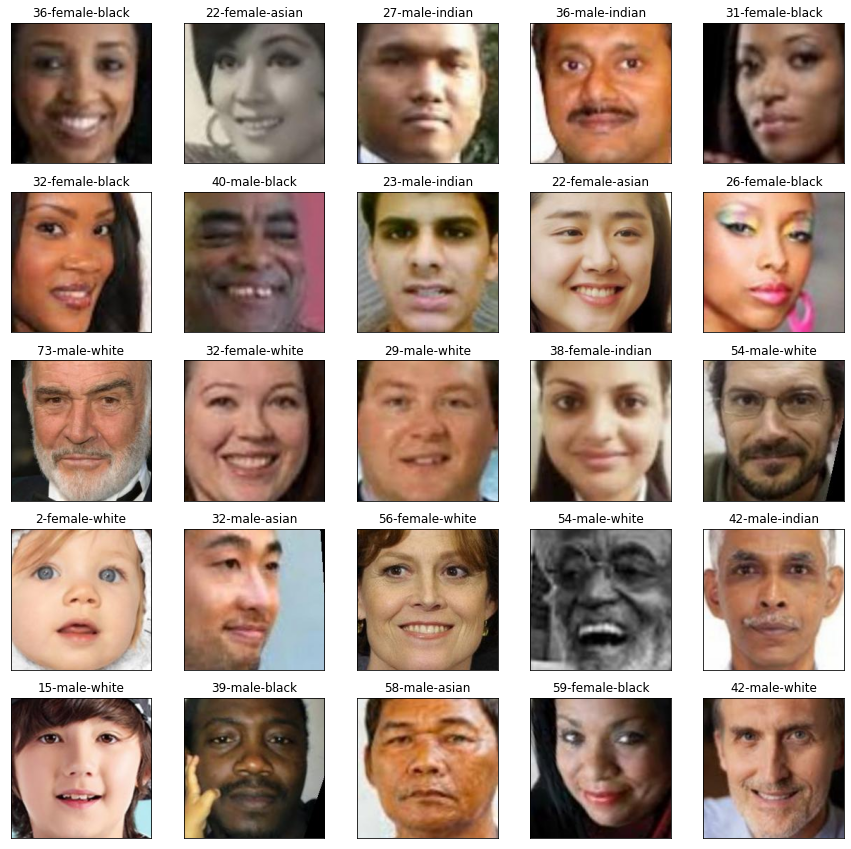

In [49]:
plt.figure( figsize=(15, 15))

idx = 1
for rows in range(5):
    dr = df.sample(n=5)
    
    for index, row in dr.iterrows():
        image = cv2.imread(row['filename'])
        label = "{}-{}-{}".format(row['age'],gender_id[row['gender']],  race_id[row['race']] )
        ax = plt.subplot(5, 5, idx)     
        ax.title.set_text(label)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow( cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        idx = idx +1
        
plt.show()

__Normalization and split data__

In [50]:
df_gr = df.groupby(['gender','race']).count()

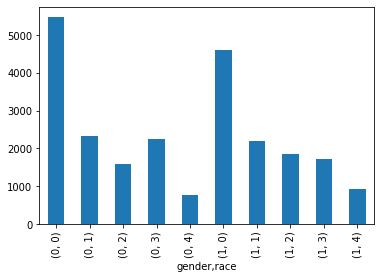

In [51]:
df_gr['filename'].plot(kind='bar');

In [52]:
df_a = df.groupby(['age']).count()

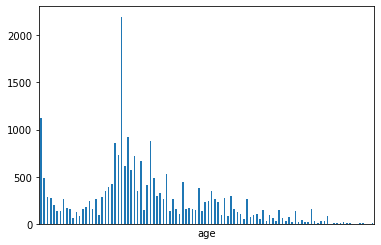

In [53]:
ax = df_a['filename'].plot(kind='bar');
ax.set_xticks([]);

In [55]:
# working with smaller dataset

df_full, df_t = train_test_split(df, test_size=0.1, random_state=42 )
df_train, df_test = train_test_split(df_t, test_size=0.1, random_state=42 )
print('training {} , testing {}'.format(len(df_train), len(df_test) ))

training 2133 , testing 238


__Image Generator__

In [68]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32, img_size = 128, rescale=1., shuffle=True):
        self.batch_size = batch_size
        self.img_size = img_size
        self.rescale = rescale
        self.df = df
        self.indices = self.df.index.tolist()
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
        
        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def __get_data(self, batch):
        dfb = self.df.loc[batch]
        
        genders = tf.keras.utils.to_categorical( dfb['gender'], 2)
        races   = tf.keras.utils.to_categorical( dfb['race']  , 5)
        ages    = dfb['age'].values/max_years
        images = []
        for file in dfb['filename']:
            image = cv2.imread(file)
            image = cv2.resize(image, (self.img_size, self.img_size))
            image = image * self.rescale
            images.append(image)

        #yield np.array(images), [ages,races, genders]
        return np.array(images), [ages,races, genders]

### First Model

<img src='images/modelA.png' />

In [74]:
def hidden_layers(inputs, filters=(16, 32, 64)):
    x = inputs
    for (i, f) in enumerate(filters):
        x = tf.keras.layers.Conv2D(f, (3, 3), padding="same", activation="relu")(x)
        x = tf.keras.layers.BatchNormalization(axis=-1)(x)
        x = tf.keras.layers.MaxPooling2D((2, 2))(x)
        
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)    
    return x

def race_branch(inputs, nraces):
    x = hidden_layers(inputs)            
    x = tf.keras.layers.Dense(nraces)(x)
    x = tf.keras.layers.Activation("softmax", name="race")(x)
    return x

def gender_branch(inputs, ngenders):
    x = hidden_layers(inputs)
    x = tf.keras.layers.Dense(ngenders)(x)
    x = tf.keras.layers.Activation("sigmoid", name="gender")(x)
    return x

def age_branch(inputs):   
    x = hidden_layers(inputs)
    x = tf.keras.layers.Dense(1)(x)
    x = tf.keras.layers.Activation("linear", name="age")(x)
    return x
 

def multi_output_A(input_shape, nraces, ngenders, lr, decay): 
    
    inputs  = tf.keras.layers.Input( shape= input_shape )
    
    race = race_branch(inputs, nraces)
    gender = gender_branch(inputs, ngenders)
    age = age_branch(inputs)  

    model = tf.keras.models.Model(inputs=inputs,  outputs = [age, race, gender], name="face_net_A")

    model.compile(optimizer=  tf.keras.optimizers.Adam(lr = lr, decay= decay ), 
                  loss={
                      'age': 'mse', 
                      'race': 'categorical_crossentropy', 
                      'gender': 'binary_crossentropy'},
                  metrics={
                      'age': 'mae', 
                      'race': 'accuracy',
                      'gender': 'accuracy'})   
    
    print( model.summary() )
    
    return model   

In [76]:
lr     = 1e-4
decay  = lr / 10
modelA = multi_output_A( (IMG_size, IMG_size, 3 ), 5, 2, lr=lr , decay=decay)

Model: "face_net_A"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 150, 150, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 150, 150, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 150, 150, 16) 448         input_1[0][0]                    
_________________________________________________________________________________________

In [78]:
#tf.keras.utils.plot_model(modelA, to_file='modelA.png', show_shapes=True)

In [159]:
batch_size = 32

train_gen = DataGenerator(df_train, 
                          batch_size=batch_size, 
                          img_size = IMG_size, 
                          rescale=1/255, 
                          shuffle=True)

test_gen  = DataGenerator(df_test,  
                          batch_size=batch_size, 
                          img_size = IMG_size, 
                          rescale=1/255, 
                          shuffle=False)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("./modelA_checkpoint", monitor='val_loss')
]

In [80]:
histA = modelA.fit(train_gen,
                steps_per_epoch=len(df_train)//batch_size,
                epochs=10,
                validation_data=test_gen,
                callbacks=callbacks,
                validation_steps=len(df_test)//batch_size)

Epoch 1/10
66/66 [==============================] - 104s 2s/step - loss: 7.5218 - age_loss: 4.5195 - race_loss: 2.2118 - gender_loss: 0.7905 - age_mae: 1.6205 - race_accuracy: 0.3466 - gender_accuracy: 0.6850 - val_loss: 2.2362 - val_age_loss: 0.1175 - val_race_loss: 1.4357 - val_gender_loss: 0.6830 - val_age_mae: 0.2955 - val_race_accuracy: 0.4375 - val_gender_accuracy: 0.6920
INFO:tensorflow:Assets written to: ./modelA_checkpoint/assets
Epoch 2/10
66/66 [==============================] - 95s 1s/step - loss: 4.2651 - age_loss: 2.5611 - race_loss: 1.2471 - gender_loss: 0.4570 - age_mae: 1.2269 - race_accuracy: 0.5764 - gender_accuracy: 0.8205 - val_loss: 3.9139 - val_age_loss: 1.5750 - val_race_loss: 1.6021 - val_gender_loss: 0.7367 - val_age_mae: 1.2288 - val_race_accuracy: 0.3661 - val_gender_accuracy: 0.5089
INFO:tensorflow:Assets written to: ./modelA_checkpoint/assets
Epoch 3/10
66/66 [==============================] - 97s 1s/step - loss: 3.7729 - age_loss: 2.3350 - race_loss: 1.08

In [81]:
modelA.save('face_modelA')

INFO:tensorflow:Assets written to: face_modelA/assets


In [82]:
dfh = pd.DataFrame(histA.history)
dfh

,loss,age_loss,race_loss,gender_loss,age_mae,race_accuracy,gender_accuracy,val_loss,val_age_loss,val_race_loss,val_gender_loss,val_age_mae,val_race_accuracy,val_gender_accuracy
0,6.126187,3.511792,1.937046,0.677347,1.427017,0.402462,0.731061,2.236199,0.117537,1.435681,0.682981,0.295501,0.437500,0.691964
1,4.071695,2.359433,1.261214,0.451046,1.193863,0.577652,0.830019,3.913851,1.575040,1.602118,0.736693,1.228757,0.366071,0.508929
2,3.657851,2.245640,1.053048,0.359162,1.157704,0.637311,0.874527,3.220492,1.217154,1.409028,0.594310,1.036291,0.455357,0.741071
3,3.514326,2.343537,0.841995,0.328793,1.149960,0.699337,0.881629,3.067341,1.195150,1.339494,0.532697,0.921166,0.486607,0.763393
4,3.111886,2.133706,0.688325,0.289855,1.115268,0.759470,0.900568,3.159151,1.563573,1.091285,0.504293,0.927926,0.602679,0.727679
5,2.725997,1.962872,0.537165,0.225960,1.079043,0.811553,0.929451,4.411070,2.921533,1.027000,0.462537,1.018577,0.611607,0.785714
6,2.735640,2.110561,0.417626,0.207454,1.093974,0.866004,0.937973,3.360149,1.986116,0.942841,0.431192,0.773239,0.678571,0.803571
7,2.330668,1.827261,0.335372,0.168035,1.038918,0.893939,0.956439,2.497124,1.172507,0.911931,0.412686,0.558079,0.714286,0.816964
8,2.194163,1.731857,0.309996,0.152310,0.999950,0.895360,0.960701,1.489292,0.156238,0.916778,0.416276,0.290847,0.727679,0.848214
9,2.056555,1.699581,0.235706,0.121269,0.992448,0.929924,0.971591,1.530022,0.172855,0.932494,0.424674,0.312208,0.723214,0.830357


<AxesSubplot:>

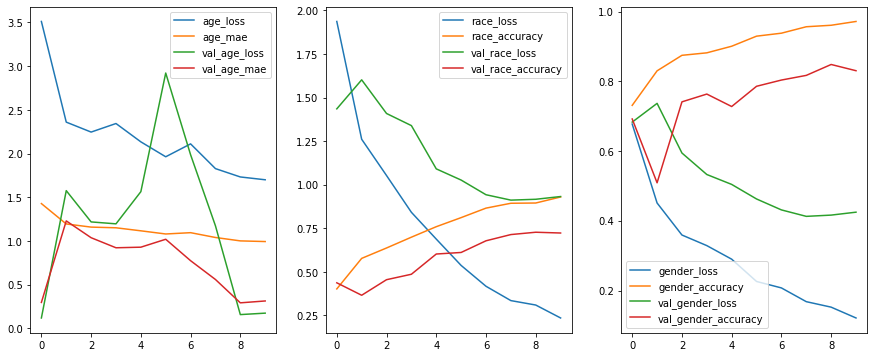

In [85]:
dfh_age = dfh[['age_loss','age_mae', 'val_age_loss', 'val_age_mae']]
dfh_race = dfh[['race_loss','race_accuracy', 'val_race_loss', 'val_race_accuracy']]
dfh_gender = dfh[['gender_loss','gender_accuracy', 'val_gender_loss', 'val_gender_accuracy']]

fig, ax = plt.subplots(1,3, figsize=(15, 6))
dfh_age.plot(ax = ax[0])
dfh_race.plot(ax = ax[1])
dfh_gender.plot(ax = ax[2])

In [154]:
def get_random_images(df, n_img,  img_size):
        dfb = df.sample(n = n_img)
        
        genders = dfb['gender'].values
        races   = dfb['race'].values
        ages    = dfb['age'].values  
        
        images = []
        imgcv2 = []
        
        for file in dfb['filename']:
            image = cv2.imread(file)
            imgcv2.append(image)
            image = cv2.resize(image, (img_size, img_size))
            image = image/255
            images.append(image)
        #yield np.array(images), [ages,races, genders]
        return imgcv2, np.array(images), ages, races, genders

    
def get_label_true( idx,  age, race , gender  ):
    label= "{}-{}-{}".format( int(age[idx]), gender_id[ int(gender[idx]) ],  race_id[ int(race[idx]) ] )
    return label

def get_label_pred( idx,  age, race , gender ): 
    v_age = int( age[ idx ]*max_years )
    
    i_race = np.argmax(race[ idx ])
    v_race = int( race[idx, i_race] *100)
    
    i_gender = np.argmax(gender[ idx ])
    v_gender = int(gender[idx, i_gender] *100)

    label = "{}--{} {}%--{} {}%".format( v_age, gender_id[i_gender], v_gender, race_id[i_race], v_race )
    return label

In [148]:
t_imgCV2 ,t_image, t_age, t_race, t_gender  = get_random_images(df, 9, IMG_size)
[o_age, o_race, o_gender] = modelA.predict(t_image)

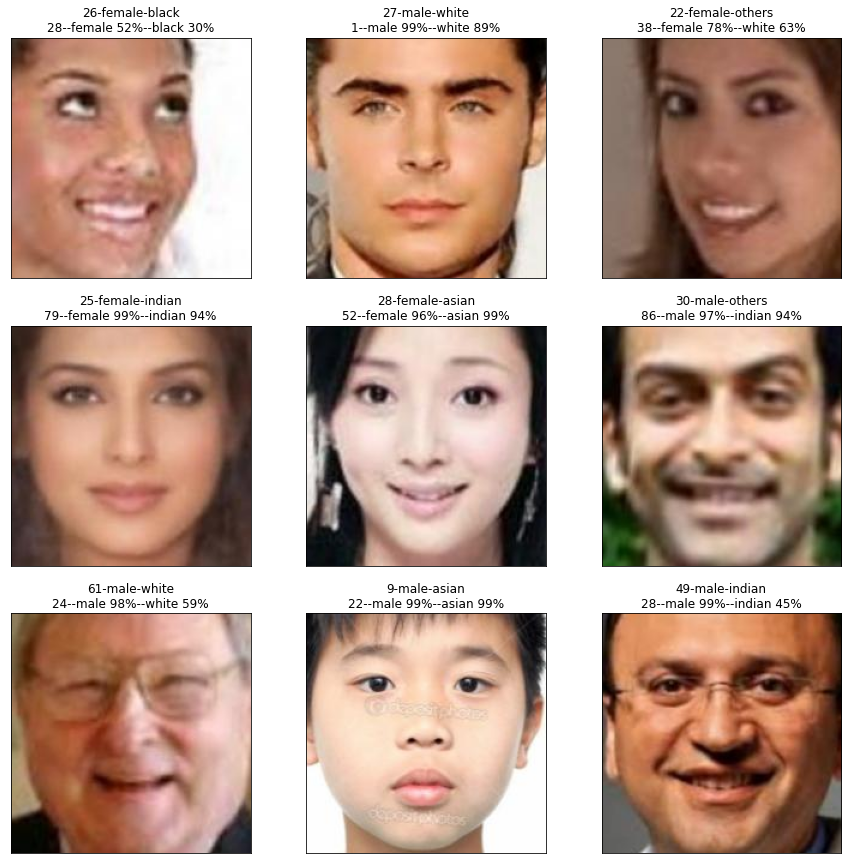

In [156]:
plt.figure( figsize=(15, 15))

idx = 0
for rows in range(3):
    for cols in range(3):
        t_label = get_label_true( idx,  t_age, t_race, t_gender  )
        p_label = get_label_pred( idx,  o_age, o_race, o_gender  )
         
        ax = plt.subplot(3, 3, idx+1)     
        ax.title.set_text( t_label+'\n'+p_label)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow( cv2.cvtColor(t_imgCV2[idx], cv2.COLOR_BGR2RGB))
        idx = idx +1
        
plt.show()

In [174]:
images = []
for file in df_test['filename']:
    image = cv2.imread(file)
    image = cv2.resize(image, (IMG_size, IMG_size))
    image = image /255.
    images.append(image)

In [176]:
[o_age, o_race, o_gender] = modelA.predict(np.array(images))

In [177]:
i_race = np.argmax(o_race, axis = 1)
t_race = df_test['race'].values

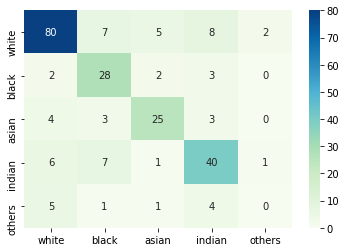

In [187]:
cm_race = confusion_matrix(t_race, i_race)
sns.heatmap(cm_race, annot=True,fmt='d', xticklabels=race_iv.keys(), yticklabels=race_iv.keys(), cmap='GnBu');

In [181]:
i_gender = np.argmax(o_gender, axis = 1)
t_gender = df_test['gender'].values

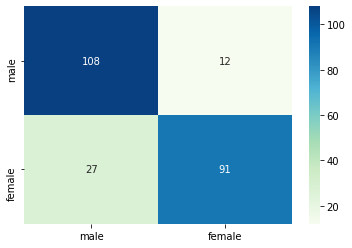

In [190]:
cm_gender = confusion_matrix(t_gender, i_gender)
sns.heatmap(cm_gender, annot=True, fmt='d', xticklabels=gender_iv.keys(), yticklabels=gender_iv.keys(), cmap='GnBu');

# Second Model

<img src='images/modelB.png'/>

In [194]:
def race_branch_2(inputs, nraces):     
    x = tf.keras.layers.Dense(nraces)(inputs)
    x = tf.keras.layers.Activation("softmax", name="race")(x)
    return x

def gender_branch_2(inputs, ngenders):
    x = tf.keras.layers.Dense(ngenders)(inputs)
    x = tf.keras.layers.Activation("sigmoid", name="gender")(x)
    return x

def age_branch_2(inputs):   
    x = tf.keras.layers.Dense(1)(inputs)
    x = tf.keras.layers.Activation("linear", name="age")(x)
    return x
 

def multi_output_B(input_shape, nraces, ngenders, lr, decay): 
    
    filters=(16, 32, 64)
    
    inputs  = tf.keras.layers.Input( shape= input_shape )
    
    x = inputs
    for (i, f) in enumerate(filters):
        x = tf.keras.layers.Conv2D(f, (3, 3), padding="same", activation="relu")(x)
        x = tf.keras.layers.BatchNormalization(axis=-1)(x)
        x = tf.keras.layers.MaxPooling2D((2, 2))(x)
        
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)    
    
    race = race_branch_2(x, nraces)
    gender = gender_branch_2(x, ngenders)
    age = age_branch_2(x)  

    model = tf.keras.models.Model(inputs=inputs,  outputs = [age, race, gender], name="face_net_B")

    model.compile(optimizer=  tf.keras.optimizers.Adam(lr = lr, decay= decay ), 
                  loss={
                      'age': 'mse', 
                      'race': 'categorical_crossentropy', 
                      'gender': 'binary_crossentropy'},
                  metrics={
                      'age': 'mae', 
                      'race': 'accuracy',
                      'gender': 'accuracy'})   
    
    print( model.summary() )
    
    return model   

In [195]:
lr     = 1e-4
decay  = lr / 10
modelB = multi_output_B( (IMG_size, IMG_size, 3 ), 5, 2, lr=lr , decay=decay)

Model: "face_net_B"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 150, 150, 16) 448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 150, 150, 16) 64          conv2d_12[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 75, 75, 16)   0           batch_normalization_16[0][0]     
_________________________________________________________________________________________

In [197]:
#tf.keras.utils.plot_model(modelB, to_file='modelB.png', show_shapes=True)

In [198]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("./modelB_checkpoint", monitor='val_loss')
]

histB = modelB.fit(train_gen,
                steps_per_epoch=len(df_train)//batch_size,
                epochs=10,
                validation_data=test_gen,
                callbacks=callbacks,
                validation_steps=len(df_test)//batch_size)

Epoch 1/10
66/66 [==============================] - 39s 562ms/step - loss: 7.3454 - age_loss: 4.1421 - race_loss: 2.2712 - gender_loss: 0.9322 - age_mae: 1.5678 - race_accuracy: 0.2559 - gender_accuracy: 0.5534 - val_loss: 2.2541 - val_age_loss: 0.0847 - val_race_loss: 1.4841 - val_gender_loss: 0.6852 - val_age_mae: 0.2462 - val_race_accuracy: 0.4420 - val_gender_accuracy: 0.5134
INFO:tensorflow:Assets written to: ./modelB_checkpoint/assets
Epoch 2/10
66/66 [==============================] - 39s 565ms/step - loss: 4.8417 - age_loss: 2.4038 - race_loss: 1.7425 - gender_loss: 0.6954 - age_mae: 1.2112 - race_accuracy: 0.3985 - gender_accuracy: 0.7014 - val_loss: 2.2875 - val_age_loss: 0.1519 - val_race_loss: 1.4075 - val_gender_loss: 0.7280 - val_age_mae: 0.3291 - val_race_accuracy: 0.4420 - val_gender_accuracy: 0.5045
INFO:tensorflow:Assets written to: ./modelB_checkpoint/assets
Epoch 3/10
66/66 [==============================] - 37s 561ms/step - loss: 4.4986 - age_loss: 2.3339 - race_lo

In [199]:
modelB.save('face_modelB')

INFO:tensorflow:Assets written to: face_modelB/assets


In [200]:
dfh = pd.DataFrame(histB.history)
dfh

,loss,age_loss,race_loss,gender_loss,age_mae,race_accuracy,gender_accuracy,val_loss,val_age_loss,val_race_loss,val_gender_loss,val_age_mae,val_race_accuracy,val_gender_accuracy
0,6.421845,3.503774,2.072829,0.845242,1.442991,0.296875,0.609848,2.254078,0.084702,1.484138,0.685238,0.246177,0.441964,0.513393
1,4.797382,2.434856,1.671159,0.691367,1.221243,0.406723,0.699811,2.287490,0.151943,1.407538,0.728008,0.329086,0.441964,0.504464
2,4.507965,2.394703,1.500653,0.612607,1.196159,0.464489,0.750000,2.218908,0.083607,1.326717,0.808585,0.219626,0.446429,0.504464
3,4.196665,2.251554,1.359973,0.585137,1.158177,0.517992,0.766572,2.309327,0.225682,1.414866,0.668779,0.363909,0.459821,0.602679
4,3.739630,1.918996,1.256423,0.564212,1.077883,0.558712,0.783617,2.256049,0.391822,1.236452,0.627775,0.533894,0.526786,0.665179
5,3.740183,2.045368,1.166811,0.528004,1.097923,0.589962,0.794034,1.881034,0.232331,1.094680,0.554022,0.391930,0.575893,0.727679
6,3.505612,1.944347,1.068022,0.493244,1.072142,0.619792,0.819602,1.712471,0.215332,0.971369,0.525770,0.375994,0.629464,0.745536
7,3.239929,1.758495,1.002149,0.479286,1.021563,0.642045,0.823390,1.610750,0.203804,0.934559,0.472387,0.367240,0.665179,0.781250
8,3.166281,1.751990,0.957103,0.457188,1.030413,0.657670,0.826231,1.513130,0.199676,0.844935,0.468519,0.362837,0.714286,0.776786
9,2.940573,1.655469,0.840673,0.444430,0.999039,0.696496,0.842330,1.516811,0.182749,0.871658,0.462404,0.338127,0.705357,0.794643


<AxesSubplot:>

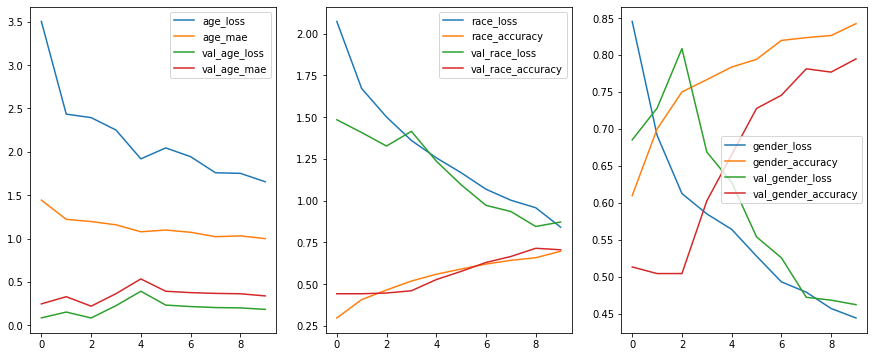

In [201]:
dfh_age = dfh[['age_loss','age_mae', 'val_age_loss', 'val_age_mae']]
dfh_race = dfh[['race_loss','race_accuracy', 'val_race_loss', 'val_race_accuracy']]
dfh_gender = dfh[['gender_loss','gender_accuracy', 'val_gender_loss', 'val_gender_accuracy']]

fig, ax = plt.subplots(1,3, figsize=(15, 6))
dfh_age.plot(ax = ax[0])
dfh_race.plot(ax = ax[1])
dfh_gender.plot(ax = ax[2])

In [202]:
[o_age, o_race, o_gender] = modelB.predict(np.array(images))

In [203]:
i_race = np.argmax(o_race, axis = 1)
t_race = df_test['race'].values

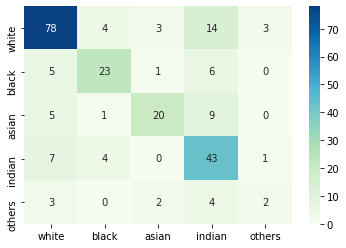

In [204]:
cm_race = confusion_matrix(t_race, i_race)
sns.heatmap(cm_race, annot=True,fmt='d', xticklabels=race_iv.keys(), yticklabels=race_iv.keys(), cmap='GnBu');

In [205]:
i_gender = np.argmax(o_gender, axis = 1)
t_gender = df_test['gender'].values

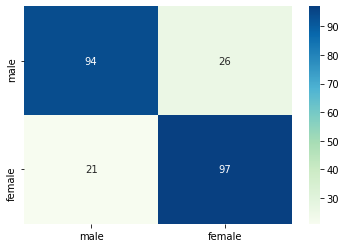

In [206]:
cm_gender = confusion_matrix(t_gender, i_gender)
sns.heatmap(cm_gender, annot=True, fmt='d', xticklabels=gender_iv.keys(), yticklabels=gender_iv.keys(), cmap='GnBu');

## Third Model. Uning pre-trained models

In [211]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3

def model_pre(model_name, input_shape, nraces, ngenders, lr, decay): 
    
    inputs  = tf.keras.layers.Input(shape=input_shape)
    
    if model_name == VGG16:
        base = VGG16( include_top = False, weights = 'imagenet', input_tensor=inputs)   
    else:
        base = InceptionV3( include_top = False, weights = 'imagenet', input_tensor=inputs)   
    
    for layer in base.layers:
        layer.trainable = False
        
    xv = tf.keras.layers.Flatten()(base.output)      
    
    race = tf.keras.layers.Dense(nraces)(xv)
    race = tf.keras.layers.Activation("softmax", name="race")(race)
    
    gender = tf.keras.layers.Dense(ngenders)(xv)
    gender = tf.keras.layers.Activation("sigmoid", name="gender")(gender)
    
    age = tf.keras.layers.Dense(1)(xv)
    age = tf.keras.layers.Activation("linear", name="age")(age)
    
    model = tf.keras.models.Model(inputs=inputs,  outputs = [age, race, gender], name="face_net_pre")

    model.compile(optimizer=  tf.keras.optimizers.Adam(lr = lr, decay= decay ), 
                  loss={
                      'age': 'mse', 
                      'race': 'categorical_crossentropy', 
                      'gender': 'binary_crossentropy'},
                   
                  metrics={
                      'age': 'mae', 
                      'race': 'accuracy',
                      'gender': 'accuracy'})   
    
    #print( model.summary() )
    
    return model   

In [212]:
lr     = 1e-4
decay  = lr / 10
modelC = model_pre( 'InceptionV3', (IMG_size, IMG_size, 3 ), 5, 2, lr=lr , decay=decay)

In [213]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("./modelC_checkpoint", monitor='val_loss')
]

histC = modelC.fit(train_gen,
                steps_per_epoch=len(df_train)//batch_size,
                epochs=10,
                validation_data=test_gen,
                callbacks=callbacks,
                validation_steps=len(df_test)//batch_size)

Epoch 1/10
66/66 [==============================] - 54s 737ms/step - loss: 3.6954 - age_loss: 1.2442 - race_loss: 1.8273 - gender_loss: 0.6239 - age_mae: 0.8592 - race_accuracy: 0.3776 - gender_accuracy: 0.7152 - val_loss: 2.4156 - val_age_loss: 0.6275 - val_race_loss: 1.2257 - val_gender_loss: 0.5623 - val_age_mae: 0.6292 - val_race_accuracy: 0.5714 - val_gender_accuracy: 0.7589
INFO:tensorflow:Assets written to: ./modelC_checkpoint/assets
Epoch 2/10
66/66 [==============================] - 48s 719ms/step - loss: 2.1639 - age_loss: 0.5308 - race_loss: 1.1699 - gender_loss: 0.4632 - age_mae: 0.5633 - race_accuracy: 0.5678 - gender_accuracy: 0.8053 - val_loss: 2.0946 - val_age_loss: 0.4249 - val_race_loss: 1.1606 - val_gender_loss: 0.5091 - val_age_mae: 0.5064 - val_race_accuracy: 0.6027 - val_gender_accuracy: 0.7679
INFO:tensorflow:Assets written to: ./modelC_checkpoint/assets
Epoch 3/10
66/66 [==============================] - 49s 741ms/step - loss: 1.7214 - age_loss: 0.3900 - race_lo

In [214]:
modelC.save('face_modelC')

INFO:tensorflow:Assets written to: face_modelC/assets


<AxesSubplot:>

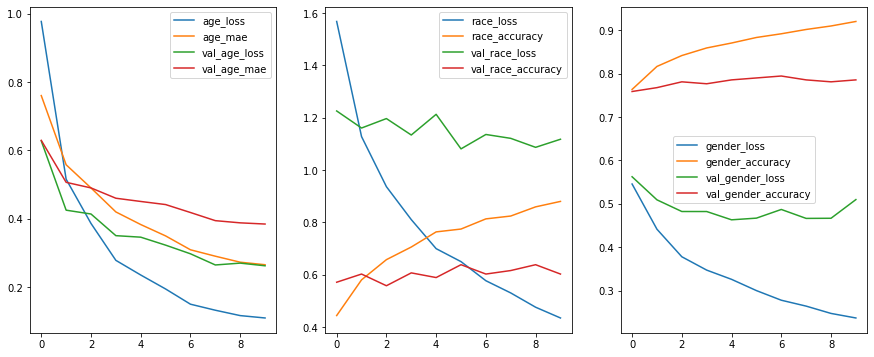

In [216]:
dfh = pd.DataFrame(histC.history)
dfh_age = dfh[['age_loss','age_mae', 'val_age_loss', 'val_age_mae']]
dfh_race = dfh[['race_loss','race_accuracy', 'val_race_loss', 'val_race_accuracy']]
dfh_gender = dfh[['gender_loss','gender_accuracy', 'val_gender_loss', 'val_gender_accuracy']]

fig, ax = plt.subplots(1,3, figsize=(15, 6))
dfh_age.plot(ax = ax[0])
dfh_race.plot(ax = ax[1])
dfh_gender.plot(ax = ax[2])

In [217]:
[o_age, o_race, o_gender] = modelC.predict(np.array(images))

In [218]:
i_race = np.argmax(o_race, axis = 1)
t_race = df_test['race'].values

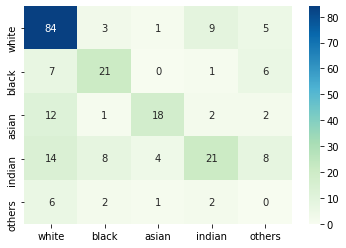

In [219]:
cm_race = confusion_matrix(t_race, i_race)
sns.heatmap(cm_race, annot=True,fmt='d', xticklabels=race_iv.keys(), yticklabels=race_iv.keys(), cmap='GnBu');

In [220]:
i_gender = np.argmax(o_gender, axis = 1)
t_gender = df_test['gender'].values

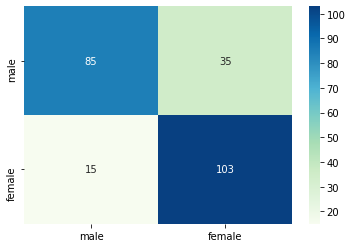

In [221]:
cm_gender = confusion_matrix(t_gender, i_gender)
sns.heatmap(cm_gender, annot=True, fmt='d', xticklabels=gender_iv.keys(), yticklabels=gender_iv.keys(), cmap='GnBu');